# Check if the denovo-db data is enriched in our prioritized z-scores

http://denovo-db.gs.washington.edu/denovo-db/Download.jsp

In [1]:
# import matplotlib
# matplotlib.use('TkAgg')

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pandas as pd
import random

import community

from scipy.stats import mannwhitneyu

import mygene
mg = mygene.MyGeneInfo()

# latex rendering of text in graphs
import matplotlib as mpl
mpl.rc('text', usetex = False)
mpl.rc('font', family = 'serif')

sns.set_style('white')

import sys

import visJS2jupyter.visJS_module
import visJS2jupyter.visualizations


% matplotlib inline

In [2]:
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

# Load the HC genes

In [2]:
# Fix inconsistent gene names
map_old_new = pd.read_csv('../../data/ASD_EPI_CHD_HC_and_DNVs_symbol_gene_description.txt',sep='\t')
map_old_new.index=map_old_new['original_symbol']
map_old_new = map_old_new['symbol']
map_old_new.head()

original_symbol
A2M          A2M
A2ML1      A2ML1
AASS        AASS
ABCA1      ABCA1
ABCA13    ABCA13
Name: symbol, dtype: object

In [3]:
ASD_HC = ['ADNP', 'ANK2', 'ARID1B', 'ASH1L', 'CHD2',
'CHD8', 'CUL3', 'DSCAM', 'DYRK1A', 'GRIN2B',
'KATNAL2', 'KDM5B', 'KMT2C', 'NCKAP1',
'POGZ', 'SCN2A', 'SUV420H1', 'SYNGAP1',
'TBR1', 'TCF7L2', 'TNRC6B', 'WAC',
'NRXN1', 'PTEN', 'SETD5', 'SHANK2',
'SHANK3', 'TRIP12',
'BCL11A', 'FOXP1', 'GIGYF1',
'ILF2', 'KDM6B', 'PHF2', 'RANBP17',
'SPAST', 'WDFY3',
'DNMT3A', 'GABRB3', 'KAT2B',
'MFRP', 'MYT1L', 'P2RX5',
'MIB1', 'SLC6A1', 'ZNF559',
'DIP2A', 'KMT2E',
'AKAP9', 'APH1A', 'CTTNBP2', 'ERBB2IP',
'ETFB', 'INTS6', 'IRF2BPL', 'MBD5', 'NAA15',
'NINL', 'OR52M1', 'PTK7', 'TRIO', 'USP45',
'ACHE', 'CAPN12', 'NLGN3']

# fix inconsistent gene names
ASD_HC = map_old_new.loc[ASD_HC].tolist()

len(ASD_HC)

65

In [4]:
# -----------------------------------------------------------------------------------------
# EPI genes from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3773011/ (329 DNMs- Table S2)

# EPI_HC_df = pd.read_excel('../data/EPI_from_jeremy/table_S2.xlsx')
# EPI_HC_df = EPI_HC_df.dropna()
# EPI_HC = list(EPI_HC_df['Gene'])
# len(EPI_HC)

# -----------------------------------------------------------------------------------------
# Other paper referenced by Jeremy -- with recurrent mutations http://www.sciencedirect.com/science/article/pii/S0002929714003838

EPI_HC = ['ALG13','CDKL5','CHD2','DNM1','FASN','GABBR2','GABRB3','GNAO1','HDAC4','KCNQ2','PIK3AP1',
         'RANGAP1','RYR3','SCN1A','SCN2A','SCN8A','SLC35A2','STXBP1']
EPI_HC = map_old_new.loc[EPI_HC].tolist()
len(EPI_HC)
# -----------------------------------------------------------------------------------------

18

In [5]:
# Load congenital heart defect recurring DNVs (from http://science.sciencemag.org/content/sci/350/6265/1262.full.pdf)

CHD_HC = ['PTPN11','KMT2D','RBFOX2','KDM5B','KRT13','MYH6','CAD','NAA15','SMAD2','RABGAP1L',
         'POGZ','JAG1','GANAB','DTNA','PPL','CHD7','ZEB2','FBN1','CHD4','AHNAK','NOTCH1']
CHD_HC = map_old_new.loc[CHD_HC].tolist()
len(CHD_HC)

21

# Load the denovo-db data

In [6]:
denovo_df = pd.read_csv('/Users/brin/Documents/CCBB_tickets_data/denovo_DB/denovo-db.variants.v.1.5.tsv',sep='\t',skiprows=1)
denovo_df.index=denovo_df['Gene']
denovo_df.head()

/Users/brin/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,#SampleID,StudyName,PubmedID,NumProbands,NumControls,SequenceType,PrimaryPhenotype,Validation,Chr,Position,...,FunctionClass,cDnaVariant,ProteinVariant,Exon/Intron,PolyPhen(HDiv),PolyPhen(HVar),SiftScore,CaddScore,LofScore,LrtScore
Gene,,,,,,,,,,,,,,,,,,,,,
DDX11L1,AU048206,Yuen2017,28263302,1625,2,genome,autism,unknown,1,13668,...,non-coding-exon,n.911G>A,NaN,exon3,-1.0,-1.0,-1.0,0.720,-1.0,-1.0
WASH7P,AU4024303,Yuen2017,28263302,1625,2,genome,autism,unknown,1,15208,...,intron,n.1233-170C>T,NaN,intron9,-1.0,-1.0,-1.0,0.493,-1.0,-1.0
WASH7P,7-0247-003,Yuen2017,28263302,1625,2,genome,autism,unknown,1,15354,...,intron,n.1233-316G>C,NaN,intron9,-1.0,-1.0,-1.0,0.460,-1.0,-1.0
WASH7P,2-1205-003,Yuen2017,28263302,1625,2,genome,autism,unknown,1,20184,...,intron,n.205-1818T>C,NaN,intron2,-1.0,-1.0,-1.0,3.602,-1.0,-1.0
NaN,AU3997301,Yuen2017,28263302,1625,2,genome,autism,unknown,1,54170,...,intergenic,NaN,NaN,intergenic,-1.0,-1.0,-1.0,0.868,-1.0,-1.0


In [7]:
print(len(denovo_df))
denovo_df.columns

283888


Index([u'#SampleID', u'StudyName', u'PubmedID', u'NumProbands', u'NumControls',
       u'SequenceType', u'PrimaryPhenotype', u'Validation', u'Chr',
       u'Position', u'Variant', u'rsID', u'DbsnpBuild', u'AncestralAllele',
       u'1000GenomeCount', u'ExacFreq', u'EspAaFreq', u'EspEaFreq',
       u'Transcript', u'codingDnaSize', u'Gene', u'FunctionClass',
       u'cDnaVariant', u'ProteinVariant', u'Exon/Intron', u'PolyPhen(HDiv)',
       u'PolyPhen(HVar)', u'SiftScore', u'CaddScore', u'LofScore',
       u'LrtScore'],
      dtype='object')

In [8]:
denovo_df[denovo_df['StudyName']=='DDD_2017']['PrimaryPhenotype'].value_counts()


developmentalDisorder    17717
Name: PrimaryPhenotype, dtype: int64

In [9]:
print('num DDD probands = ' + str(len(denovo_df[(denovo_df['StudyName']=='DDD_2017')]['#SampleID'].unique())))
print('num_variants = ' + str(len(denovo_df[(denovo_df['StudyName']=='DDD_2017')])))

num DDD probands = 3664
num_variants = 17717


In [10]:
denovo_df[(denovo_df['StudyName']=='DDD_2017')]['PrimaryPhenotype'].value_counts()

developmentalDisorder    17717
Name: PrimaryPhenotype, dtype: int64

In [11]:
DDD_df = denovo_df[(denovo_df['StudyName']=='DDD_2017')&(denovo_df['FunctionClass']!='synonymous')&(denovo_df['LofScore']>0)]
DDD_df.index=DDD_df['Gene']
DDD_genes = DDD_df['Gene'].unique().tolist()
print('num filtered probands = ' + str(len(DDD_df['#SampleID'].value_counts())))
print('num filtered variants = ' + str(len(DDD_df)))
print('num filtered genes = '+str(len(DDD_genes)))
DDD_df.head()

num filtered probands = 970
num filtered variants = 2537
num filtered genes = 647


,#SampleID,StudyName,PubmedID,NumProbands,NumControls,SequenceType,PrimaryPhenotype,Validation,Chr,Position,...,FunctionClass,cDnaVariant,ProteinVariant,Exon/Intron,PolyPhen(HDiv),PolyPhen(HVar),SiftScore,CaddScore,LofScore,LrtScore
Gene,,,,,,,,,,,,,,,,,,,,,
AGRN,DDD4K.04138,DDD_2017,28135719,4293,0,exome,developmentalDisorder,unknown,1,982099,...,codingComplex,c.3234_3235insG,p.(G1081Wfs*35),exon18,-1.0,-1.0,-1.0,-1.00,1.0,-1.0
KIAA1751,DDD4K.00346,DDD_2017,28135719,4293,0,exome,developmentalDisorder,unknown,1,1891448,...,frameshift,c.1714_1715del2,p.(L572Vfs*7),exon15,-1.0,-1.0,-1.0,-1.00,1.0,-1.0
CCDC27,DDD4K.03091,DDD_2017,28135719,4293,0,exome,developmentalDisorder,unknown,1,3673409,...,frameshift,c.666_667insGA,p.(L223Dfs*2),exon4,-1.0,-1.0,-1.0,-1.00,1.0,-1.0
CHD5,DDD4K.01394,DDD_2017,28135719,4293,0,exome,developmentalDisorder,unknown,1,6185825,...,splice-donor,c.4171+1G>T,NaN,intron27,-1.0,-1.0,-1.0,14.33,1.0,-1.0
CHD5,DDD4K.01358,DDD_2017,28135719,4293,0,exome,developmentalDisorder,unknown,1,6185825,...,splice-donor,c.4171+1G>A,NaN,intron27,-1.0,-1.0,-1.0,14.53,1.0,-1.0


In [12]:
len(DDD_df['Gene'].value_counts())

647

In [13]:
denovo_df['StudyName'].value_counts()

Yuen2017                   191633
DDD_2017                    17717
Yuen2016                    16014
GONL                        15896
Turner2016                  12882
Iossifov                    10445
Krumm                        3488
DeRubeis2014                 3408
Homsy2015                    2755
Lelieveld2016                2139
Michaelson2012               1874
Fromer2014                   1321
Sifrim2016                   1081
epi4k2013                     745
Gulsuner2013                  383
Rauch2012                     239
ASD3                          237
Helbig2016                    222
deLigt2012                    183
Kataoka2016                   123
McCarthy2014                  111
ASD1_2                         91
Yu2015                         85
Besenbacher2014                82
Hashimoto2015                  82
Lemay2015                      78
Ramu2013                       76
Lifton                         67
Halvardson2016                 65
Conrad2011    

# Load the z-score results

In [14]:
# load previously computed z-scores
import scipy

num_reps = 5000
focal_interactome='GIANT_p2'
rand_method = 'degree_binning' # can be 'degree_binning' or 'degree_ks_test'


z_ASD = pd.read_csv('../z_score_results/z_ASD_'+str(num_reps)+'_reps'+focal_interactome+'_'+rand_method+'.tsv',
                    sep='\t',names=['gene','zscore'],index_col='gene')
z_CHD = pd.read_csv('../z_score_results/z_CHD_'+str(num_reps)+'_reps'+focal_interactome+'_'+rand_method+'.tsv',
                    sep='\t',names=['gene','zscore'],index_col='gene')
z_EPI = pd.read_csv('../z_score_results/z_EPI_'+str(num_reps)+'_reps'+focal_interactome+'_'+rand_method+'.tsv',
                    sep='\t',names=['gene','zscore'],index_col='gene')

# reload the focal interactome and recalculate Wprime
if focal_interactome=='GIANT_p3':
    Gint = nx.read_gpickle('../G_giant_.3.gpickle')
elif focal_interactome=='GIANT_p25':
    Gint = nx.read_gpickle('../G_giant_.25.gpickle')
elif focal_interactome=='GIANT_p2':
    Gint = nx.read_gpickle('../G_giant_.2.gpickle')
elif focal_interactome=='GIANT_p15':
    Gint = nx.read_gpickle('../G_giant_.15.gpickle')
elif focal_interactome=='GIANT_full_p2':
    Gint = nx.read_gpickle('../G_giant_full.2.gpickle')
elif focal_interactome=='GIANT_kidney_p2':
    Gint = nx.read_gpickle('../kidney_0.2.gpickle')
elif focal_interactome=='GIANT_neuron_p3':
    Gint = nx.read_gpickle('../G_giant_neuron.3.gpickle')
elif focal_interactome=='GIANT_heart_p2':
    Gint = nx.read_gpickle('../G_giant_heart.2.gpickle')
elif focal_interactome=='Menche':
    Gint = nx.read_gpickle('../G_menche.gpickle')
elif focal_interactome=='STRING':
    Gint = nx.read_gpickle('../G_str.gpickle')
elif focal_interactome=='inBIO':
    Gint = nx.read_gpickle('../G_inbio.gpickle')

Wprime = visJS2jupyter.visualizations.normalized_adj_matrix(Gint,conserve_heat=True)

z_ASD = z_ASD['zscore'].copy()
z_CHD = z_CHD['zscore'].copy()
z_EPI = z_EPI['zscore'].copy()

                    

    

In [15]:
# load previously computed paired z-scores
import scipy

z_ASD_CHD = pd.read_csv('../z_score_results/z_ASD_CHD'+str(num_reps)+'_reps'+focal_interactome+'_'+rand_method+'.tsv',
                    sep='\t',names=['gene','zscore'],index_col='gene')
z_ASD_CHD = z_ASD_CHD['zscore'].copy()

z_ASD_EPI = pd.read_csv('../z_score_results/z_ASD_EPI'+str(num_reps)+'_reps'+focal_interactome+'_'+rand_method+'.tsv',
                    sep='\t',names=['gene','zscore'],index_col='gene')
z_ASD_EPI = z_ASD_EPI['zscore'].copy()

                    

    

# Check for enrichment in DDD variants

In [16]:
ASD_in_G = np.intersect1d(Gint.nodes(),ASD_HC)
CHD_in_G = np.intersect1d(Gint.nodes(),CHD_HC)
EPI_in_G = np.intersect1d(Gint.nodes(),EPI_HC)

76
518
1060
14563
ASD enrichment = 1.139980618217199e-09
57
518
907
14563
CHD enrichment = 9.489524866809825e-06
116
518
1435
14563
ASD-CHD enrichment = 2.67711912783901e-18


Text(0,0.5,u'number recovered DDD DNVs')

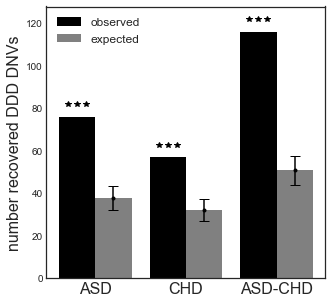

In [17]:
# compare how many NDD DNVs are recovered above z = zthresh

zthresh = 2
num_reps=1000

include_seeds = False


# what about single ASD z-scores?
if include_seeds:
    z_ASD_g1 = z_ASD
else:
    z_ASD_g1 = z_ASD.drop(list(np.intersect1d(z_ASD.index,CHD_HC+ASD_HC))) #list(np.setdiff1d(z_ASD_g1,CHD_HC+ASD_HC)) # don't include seeds
z_ASD_g1 = z_ASD_g1[z_ASD_g1>zthresh].index.tolist()

if include_seeds:
    DDD_inG = DDD_genes
    
else:
    DDD_inG = list(np.setdiff1d(DDD_genes,CHD_HC+ASD_HC))
    
DDD_inG = list(np.intersect1d(DDD_inG,Gint.nodes()))

ASD_g1 = np.intersect1d(DDD_inG,z_ASD_g1)

print(len(ASD_g1))
print(len(DDD_inG))
print(len(z_ASD_g1))
print(len(z_ASD))

M = len(z_ASD)
n=len(DDD_inG)
N = len(z_ASD_g1)
k=len(ASD_g1)

ASD_p = scipy.stats.hypergeom.sf(k,M,n,N)
print('ASD enrichment = ' + str(scipy.stats.hypergeom.sf(k,M,n,N)))

# calculate random expectation
exp_temp_ASD = []
for r in range(num_reps):
    # calculate how many you expect to recover given hypergeo distribution
    DDD_shuffled = z_ASD.index.tolist()
    np.random.shuffle(DDD_shuffled)
    DDD_shuffled = DDD_shuffled[:len(DDD_inG)]
    exp_temp_ASD.append(len(np.intersect1d(DDD_shuffled,z_ASD_g1)))
    
    

# ---------------------------------------------------------------------------
# what about single CHD z-scores?
if include_seeds:
    z_CHD_g1 = z_CHD
else:
    z_CHD_g1 = z_CHD.drop(list(np.intersect1d(z_CHD.index,CHD_HC+ASD_HC))) # don't include seeds
z_CHD_g1 = z_CHD_g1[z_CHD_g1>zthresh].index.tolist()

if include_seeds:
    DDD_inG = DDD_genes
    
else:
    DDD_inG = list(np.setdiff1d(DDD_genes,CHD_HC+ASD_HC))
DDD_inG = list(np.intersect1d(DDD_inG,Gint.nodes()))

CHD_g1 = np.intersect1d(DDD_inG,z_CHD_g1)

print(len(CHD_g1))
print(len(DDD_inG))
print(len(z_CHD_g1))
print(len(z_CHD))

M = len(z_CHD)
n=len(DDD_inG)
N = len(z_CHD_g1)
k=len(CHD_g1)

CHD_p = scipy.stats.hypergeom.sf(k,M,n,N)
print('CHD enrichment = ' + str(scipy.stats.hypergeom.sf(k,M,n,N)))

# calculate random expectation
exp_temp_CHD = []
for r in range(num_reps):
    # calculate how many you expect to recover given hypergeo distribution
    DDD_shuffled = z_CHD.index.tolist()
    np.random.shuffle(DDD_shuffled)
    DDD_shuffled = DDD_shuffled[:len(DDD_inG)]
    exp_temp_CHD.append(len(np.intersect1d(DDD_shuffled,z_CHD_g1)))
    
    
# ---------------------------------------------------------------------------
# combined ASD-CHD z-scores?

# ---- use the combined z-scores ---- 
z_both_g1 = z_ASD_CHD.sort_values(ascending=False)


# ---- OR multiply the individual z-scores ----
# z_both_g1 = z_ASD[(z_ASD>zthresh)*(z_CHD>zthresh)].index.tolist()
# z_both_g1 = z_CHD*z_ASD*(z_CHD>0)*(z_ASD>0)

if include_seeds:
    z_both_g1 = z_both_g1
else:
    z_both_g1 = z_both_g1.drop(np.intersect1d(z_both_g1.index,CHD_HC+ASD_HC))  # don't include seeds
z_both_g1 = z_both_g1[z_both_g1>zthresh].index.tolist()


if include_seeds:
    DDD_inG = DDD_genes
    
else:
    DDD_inG = list(np.setdiff1d(DDD_genes,CHD_HC+ASD_HC))
DDD_inG = list(np.intersect1d(DDD_inG,Gint.nodes()))

both_g1 = np.intersect1d(DDD_inG,z_both_g1)

print(len(both_g1))
print(len(DDD_inG))
print(len(z_both_g1))
print(len(z_CHD))

M = len(z_CHD)
n=len(DDD_inG)
N = len(z_both_g1)
k=len(both_g1)

both_p = scipy.stats.hypergeom.sf(k,M,n,N)
print('ASD-CHD enrichment = ' + str(scipy.stats.hypergeom.sf(k,M,n,N)))

# calculate random expectation
exp_temp_both = []
for r in range(num_reps):
    # calculate how many you expect to recover given hypergeo distribution
    DDD_shuffled = z_CHD.index.tolist()
    np.random.shuffle(DDD_shuffled)
    DDD_shuffled = DDD_shuffled[:len(DDD_inG)]
    exp_temp_both.append(len(np.intersect1d(DDD_shuffled,z_both_g1)))



# -------------------------------------------
# plot the results
plt.figure(figsize=(5,5))

recovered_list = [len(ASD_g1),len(CHD_g1),len(both_g1)]
pval_list = [ASD_p,CHD_p,both_p]

plt.bar([0,1,2],recovered_list,width=.4,color='k',label='observed')
plt.bar([0.4,1.4,2.4],[np.mean(exp_temp_ASD),np.mean(exp_temp_CHD),np.mean(exp_temp_both)],width=.4,color='gray',
       label='expected')

plt.errorbar([0.4,1.4,2.4],[np.mean(exp_temp_ASD),np.mean(exp_temp_CHD),np.mean(exp_temp_both)],
             [np.std(exp_temp_ASD),np.std(exp_temp_CHD),np.std(exp_temp_both)],fmt='k.',ecolor='k',capsize=5.0)

# add stars for significance
for i in [0,1,2]:
    star_height = recovered_list[i]+max(recovered_list)*0.05 # add 5% of max to value
    if (pval_list[i] < 0.05) & (pval_list[i]>0.01):
        plt.plot([i],[star_height],'k*')
    elif (pval_list[i] <= 0.01) & (pval_list[i]>0.001):
        plt.plot([i-.05,i+.05],[star_height]*2,'k*')
    elif (pval_list[i] <= 0.001):
        plt.plot([i-.1,i,i+.1],[star_height]*3,'k*')
        
plt.legend(loc='best',fontsize=12)
plt.xticks([0.2,1.2,2.2],['ASD','CHD','ASD-CHD'],fontsize=16)
plt.ylabel('number recovered DDD DNVs',fontsize=16)

#plt.savefig('../../manuscript/figures_18_02/'+focal_interactome+'/z_score_num_recovered_DDD_DNVs_ASD-CHD_'+str(zthresh)+'combined_product_includeseeds'+str(include_seeds)+'.pdf',
#          dpi=300,bbox_inches='tight')

In [18]:
both_g1

array([u'ADD1', u'AKT3', u'ANKHD1-EIF4EBP3', u'ANKRD11', u'ANKRD12',
       u'ASAP2', u'ASXL1', u'AUTS2', u'BAZ2B', u'BBX', u'BCL11B', u'BPTF',
       u'BRD1', u'BRD4', u'BRWD3', u'CASK', u'CBL', u'CCDC88A', u'CDAN1',
       u'CDK13', u'CNOT1', u'CRB1', u'CREBBP', u'CSPP1', u'CTNNB1',
       u'DAAM1', u'DMXL2', u'DOPEY1', u'DST', u'DYNC1LI2', u'EBF3',
       u'EHMT1', u'EP300', u'FBXO11', u'FCHSD2', u'GATAD2B', u'GTDC1',
       u'HECTD1', u'HECW2', u'HIVEP2', u'IBTK', u'JMJD1C', u'KANSL1',
       u'KANSL1L', u'KAT6A', u'KAT6B', u'KDM3B', u'KDM6A', u'KIDINS220',
       u'KMT2A', u'LDB1', u'LRRFIP2', u'MED13L', u'MEIS2', u'MSL3',
       u'MYH10', u'NF1', u'NFIB', u'NIN', u'OTX2', u'PCDHGA1', u'PGM2L1',
       u'PHIP', u'PLCG1', u'PPFIA2', u'PPM1D', u'PPP1R12A', u'PPP2R3A',
       u'PSD3', u'PTPRO', u'PURA', u'RASGEF1A', u'RBMS1', u'RC3H2',
       u'RFX7', u'RNF111', u'SAFB', u'SALL3', u'SATB2', u'SCAF11',
       u'SETD1B', u'SETD2', u'SIPA1L1', u'SLC12A2', u'SON', u'SOX5',
       u'SPEN'

In [19]:
denovo_AC = denovo_df.loc[list(both_g1)]
denovo_AC = denovo_AC[(denovo_AC['FunctionClass']!='synonymous')&(denovo_AC['LofScore']>0)]
len(denovo_AC)


1042

In [20]:
denovo_AC.head()

,#SampleID,StudyName,PubmedID,NumProbands,NumControls,SequenceType,PrimaryPhenotype,Validation,Chr,Position,...,FunctionClass,cDnaVariant,ProteinVariant,Exon/Intron,PolyPhen(HDiv),PolyPhen(HVar),SiftScore,CaddScore,LofScore,LrtScore
Gene,,,,,,,,,,,,,,,,,,,,,
ADD1,DDD4K.01683,DDD_2017,28135719,4293,0,exome,developmentalDisorder,yes,4,2901062,...,codingComplex,c.1061_1062insT,p.(S355Ffs*20),exon9,-1.0,-1.0,-1.0,-1.0,1.0,-1.0
ADD1,DDD4K.01683,DDD_2017,28135719,4293,0,exome,developmentalDisorder,yes,4,2901062,...,codingComplex,c.1061_1062insT,p.(S355Ffs*20),exon9,-1.0,-1.0,-1.0,-1.0,1.0,-1.0
ADD1,DDD4K.01683,DDD_2017,28135719,4293,0,exome,developmentalDisorder,yes,4,2901062,...,codingComplex,c.1061_1062insT,p.(S355Ffs*20),exon9,-1.0,-1.0,-1.0,-1.0,1.0,-1.0
ADD1,DDD4K.01683,DDD_2017,28135719,4293,0,exome,developmentalDisorder,yes,4,2901062,...,codingComplex,c.1061_1062insT,p.(S355Ffs*20),exon9,-1.0,-1.0,-1.0,-1.0,1.0,-1.0
AKT3,DDD4K.00542,DDD_2017,28135719,4293,0,exome,developmentalDisorder,unknown,1,243858886,...,intron-near-splice,c.172+3_172+6del4,NaN,intron2,-1.0,-1.0,-1.0,-1.0,1.0,-1.0


In [21]:
denovo_AC['PrimaryPhenotype'].value_counts()

developmentalDisorder       782
intellectualDisability       94
autism                       73
congenital_heart_disease     66
epilepsy                     19
control                       5
schizophrenia                 3
Name: PrimaryPhenotype, dtype: int64

In [22]:
denovo_AC.index=denovo_AC['#SampleID']
denovo_AC_gb_proband = denovo_AC[~denovo_AC.index.duplicated(keep='first')]
denovo_AC_gb_proband.index = denovo_AC_gb_proband['Gene']
denovo_AC_gb_proband = denovo_AC_gb_proband[denovo_AC_gb_proband['PrimaryPhenotype']!='control'] # drop controls
denovo_AC_gb_proband.head()

,#SampleID,StudyName,PubmedID,NumProbands,NumControls,SequenceType,PrimaryPhenotype,Validation,Chr,Position,...,FunctionClass,cDnaVariant,ProteinVariant,Exon/Intron,PolyPhen(HDiv),PolyPhen(HVar),SiftScore,CaddScore,LofScore,LrtScore
Gene,,,,,,,,,,,,,,,,,,,,,
ADD1,DDD4K.01683,DDD_2017,28135719,4293,0,exome,developmentalDisorder,yes,4,2901062,...,codingComplex,c.1061_1062insT,p.(S355Ffs*20),exon9,-1.0,-1.0,-1.0,-1.00,1.00,-1.0
AKT3,DDD4K.00542,DDD_2017,28135719,4293,0,exome,developmentalDisorder,unknown,1,243858886,...,intron-near-splice,c.172+3_172+6del4,NaN,intron2,-1.0,-1.0,-1.0,-1.00,1.00,-1.0
ANKHD1-EIF4EBP3,DDD4K.02548,DDD_2017,28135719,4293,0,exome,developmentalDisorder,unknown,5,139918502,...,splice-acceptor,c.7405-2A>T,NaN,intron32,-1.0,-1.0,-1.0,17.05,0.25,-1.0
ANKRD11,DDD4K.00569,DDD_2017,28135719,4293,0,exome,developmentalDisorder,unknown,16,89346589,...,frameshift,c.6357_6360del4,p.(W2120Rfs*54),exon9,-1.0,-1.0,-1.0,-1.00,0.75,-1.0
ANKRD11,DDD4K.02132,DDD_2017,28135719,4293,0,exome,developmentalDisorder,unknown,16,89346766,...,frameshift,c.6183del1,p.(L2062Wfs*25),exon9,-1.0,-1.0,-1.0,-1.00,0.75,-1.0


In [23]:
len(denovo_AC_gb_proband)

407

In [24]:
# these are the genes in DDD which are also in the ASD-CHD interactome (115 of them, out of ~1000 in ASD-CHD interactome)

# save the value counts to a file, for integration with other datasets
#denovo_AC_gb_proband['Gene'].value_counts().to_csv('../../manuscript/tables_18_02/DDD_in_ASD_CHD_interactome.tsv',sep='\t')

denovo_AC_gb_proband['Gene'].value_counts()

ANKRD11            41
KMT2A              35
CTNNB1             18
MED13L             16
KAT6B              13
EP300              13
TCF4               11
GATAD2B            10
KANSL1              9
KAT6A               9
SATB2               9
PURA                8
EHMT1               8
USP9X               7
CASK                6
PPM1D               6
AUTS2               5
SON                 5
TBL1XR1             5
SRRM2               5
PHIP                5
SOX5                5
MSL3                4
TCF12               4
SPEN                4
KDM6A               4
ASXL1               4
MEIS2               4
SETD2               4
ZNF292              4
                   ..
ZMYM2               1
ASAP2               1
PPP1R12A            1
DAAM1               1
ZBTB20              1
IBTK                1
DYNC1LI2            1
PTPRO               1
PCDHGA1             1
SETD1B              1
TRAK1               1
CSPP1               1
LRRFIP2             1
DMXL2               1
BCL11B    

In [25]:
pheno_list = denovo_AC_gb_proband['PrimaryPhenotype'].value_counts().index.tolist()
pheno_list

['developmentalDisorder',
 'intellectualDisability',
 'autism',
 'congenital_heart_disease',
 'epilepsy',
 'schizophrenia']

In [26]:
# make a barchart of the most common genes and their primary phenotypes
gene_VC = denovo_AC_gb_proband['Gene'].value_counts()
focal_genes = gene_VC[gene_VC>1].index.tolist()
gene_pheno_df = pd.DataFrame(np.zeros((len(pheno_list),len(focal_genes))),index=pheno_list)
gene_pheno_df.columns=focal_genes
for pheno in pheno_list:
    for g in focal_genes:
        focal_df = denovo_AC_gb_proband.loc[g]
        if type(focal_df)==pd.core.series.Series: # check if focal_df has just one element and got cast to a series
            if pheno in focal_df['PrimaryPhenotype']:
                gene_pheno_df[g].loc[pheno]=1.0
            else:
                gene_pheno_df[g].loc[pheno]=0.0
        else:
            if pheno in focal_df['PrimaryPhenotype'].tolist():
                gene_pheno_df[g].loc[pheno]=float(sum(focal_df['PrimaryPhenotype']==pheno))
            else:
                gene_pheno_df[g].loc[pheno]=0.0
            
gene_pheno_df

,ANKRD11,KMT2A,CTNNB1,MED13L,KAT6B,EP300,TCF4,GATAD2B,KANSL1,KAT6A,...,HECTD1,ZNF623,DST,BPTF,ANKRD12,CDAN1,TOP2B,CNOT1,VEZF1,NF1
developmentalDisorder,32.0,26.0,11.0,13.0,6.0,10.0,9.0,7.0,8.0,7.0,...,1.0,1.0,1.0,2.0,1.0,1.0,2.0,1.0,2.0,1.0
intellectualDisability,3.0,2.0,5.0,1.0,5.0,1.0,1.0,3.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
autism,4.0,5.0,1.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
congenital_heart_disease,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
epilepsy,1.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
schizophrenia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
len(focal_genes)

63

(0, 42)

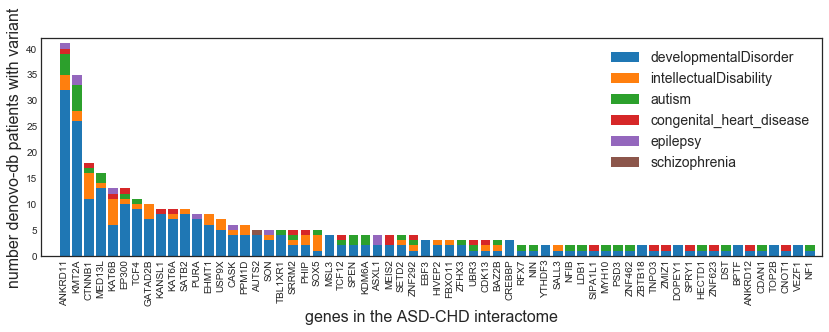

In [28]:
plt.figure(figsize=(14,4))
plt.bar(range(len(focal_genes)),gene_pheno_df.loc['developmentalDisorder'],label='developmentalDisorder')
plt.bar(range(len(focal_genes)),gene_pheno_df.loc['intellectualDisability'],bottom = gene_pheno_df.loc['developmentalDisorder'],
       label='intellectualDisability')
plt.bar(range(len(focal_genes)),gene_pheno_df.loc['autism'],
        bottom = gene_pheno_df.loc['developmentalDisorder']+gene_pheno_df.loc['intellectualDisability'],
       label='autism')
plt.bar(range(len(focal_genes)),gene_pheno_df.loc['congenital_heart_disease'],
        bottom = gene_pheno_df.loc['developmentalDisorder']+gene_pheno_df.loc['intellectualDisability']+gene_pheno_df.loc['autism'],
       label='congenital_heart_disease')
plt.bar(range(len(focal_genes)),gene_pheno_df.loc['epilepsy'],
        bottom = gene_pheno_df.loc['developmentalDisorder']+gene_pheno_df.loc['intellectualDisability']+gene_pheno_df.loc['autism']+gene_pheno_df.loc['congenital_heart_disease'],
       label='epilepsy')
plt.bar(range(len(focal_genes)),gene_pheno_df.loc['schizophrenia'],
        bottom = gene_pheno_df.loc['developmentalDisorder']+gene_pheno_df.loc['intellectualDisability']+
        gene_pheno_df.loc['autism']+gene_pheno_df.loc['congenital_heart_disease']+gene_pheno_df.loc['epilepsy'],
       label='schizophrenia')
plt.legend(loc='best',fontsize=14)
plt.ylabel('number denovo-db patients with variant',fontsize=16)
plt.xlabel('genes in the ASD-CHD interactome',fontsize=16)
plt.xticks(range(len(focal_genes)),focal_genes,rotation=90)
plt.xlim([-2,len(focal_genes)])
plt.ylim([0,42])
# plt.savefig('../../manuscript/figures_18_02/'+focal_interactome+'/num_DDD_patients_in_ASD_CHD_interactome_by_disorder.pdf',
#           dpi=300,bbox_inches='tight')

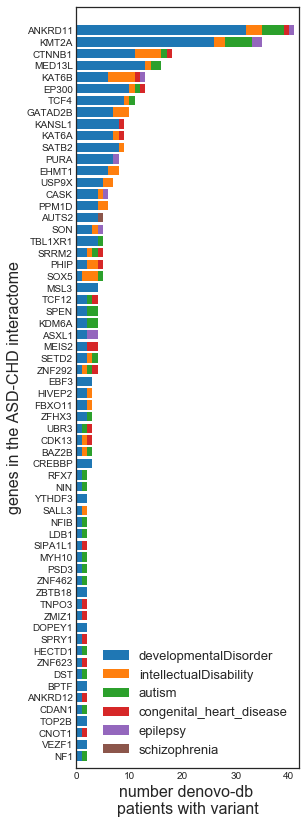

In [29]:
# plot vertically instead
plt.figure(figsize=(4,14))
plt.barh(range(len(focal_genes)),gene_pheno_df.loc['developmentalDisorder'],label='developmentalDisorder')
plt.barh(range(len(focal_genes)),gene_pheno_df.loc['intellectualDisability'],left = gene_pheno_df.loc['developmentalDisorder'],
       label='intellectualDisability')
plt.barh(range(len(focal_genes)),gene_pheno_df.loc['autism'],
        left = gene_pheno_df.loc['developmentalDisorder']+gene_pheno_df.loc['intellectualDisability'],
       label='autism')
plt.barh(range(len(focal_genes)),gene_pheno_df.loc['congenital_heart_disease'],
        left = gene_pheno_df.loc['developmentalDisorder']+gene_pheno_df.loc['intellectualDisability']+gene_pheno_df.loc['autism'],
       label='congenital_heart_disease')
plt.barh(range(len(focal_genes)),gene_pheno_df.loc['epilepsy'],
        left = gene_pheno_df.loc['developmentalDisorder']+gene_pheno_df.loc['intellectualDisability']+gene_pheno_df.loc['autism']+gene_pheno_df.loc['congenital_heart_disease'],
       label='epilepsy')
plt.barh(range(len(focal_genes)),gene_pheno_df.loc['schizophrenia'],
        left = gene_pheno_df.loc['developmentalDisorder']+gene_pheno_df.loc['intellectualDisability']+
        gene_pheno_df.loc['autism']+gene_pheno_df.loc['congenital_heart_disease']+gene_pheno_df.loc['epilepsy'],
       label='schizophrenia')
plt.legend(loc='best',fontsize=13)
plt.xlabel('number denovo-db \npatients with variant',fontsize=16)
plt.ylabel('genes in the ASD-CHD interactome',fontsize=16)
tmp = plt.yticks(range(len(focal_genes)),focal_genes)

plt.ylim([-2,len(focal_genes)])
plt.xlim([0,42])

ax = plt.gca()
ax.invert_yaxis()

# plt.savefig('../../manuscript/figures_18_02/'+focal_interactome+'/num_DDD_patients_in_ASD_CHD_interactome_by_disorder.pdf',
#           dpi=300,bbox_inches='tight')

In [30]:
z_ASD_CHD.loc['CFTR']

-0.40401892503799997